# **San Francisco Airport (SFO) traffic analysis**

source: [kaggle project](kaggle.com/code/datark1/airport-traffic-eda-sarima-prophet-and-lstm)

San Francisco International Airport (IATA code: SFO) is located south of San Francisco downtown and it’s a major West Coast air transportation hub. It serves both domestic and international (also trans-Pacific) flights. It's equipped with 4 asphalt runways – two perpendicular pairs. This airport is one of the main hubs for the United Airline which generates relatively a big chunk of the airport's traffic. It is also worth checking [airport's annual report ](https://s3.amazonaws.com/media.flysfo.com/2017_Annual_Report.pdf) to learn more about the operational side of the airport. You can find there, for example, that only 59% of the income is from aviation operations (which is currently a quite typical share in various airports' income). The remaining part comes from concessions (retail), parking fees and transportation.

In this kernel, we will explore airport traffic statistics and we'll build some bsic forecasting models.

---
**EDA Highlights**
* Passengers traffic **steadily grows** from 2005 through 2018
* **The highest number** of passengers is reported so far is in August 2017: **5 497 000** people.
* There is a visible **peak in** the traffic during the **holiday period**
* Most of the flights are **domestic**
* Most of the flights are operated by **narrow body aircraft** (e.g. Boeing 737, Airbus 320)
* The biggest share in a traffic generation has the **United Airlines** (over 57%)
* SARIMAX model predicts that **in 2022** the airport's traffic will be between **5 and 7 million** passengers with confidence intervals between 3.5-8.5 million

<a title="Andrew Choy from Santa Clara, California [CC BY-SA 2.0 (https://creativecommons.org/licenses/by-sa/2.0)], via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:San_Francisco_International_Airport_at_night.jpg"><img width="1024" alt="San Francisco International Airport at night" src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d6/San_Francisco_International_Airport_at_night.jpg/1024px-San_Francisco_International_Airport_at_night.jpg"></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # data visualisation
import matplotlib.pyplot as plt # data visualisation
import datetime as dt # working with time data

import warnings  
warnings.filterwarnings('ignore')

print(f"Numpy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Seaborn version: {sns.__version__}")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Numpy version: 1.23.5
Pandas version: 1.5.3
Seaborn version: 0.12.2


# 1 EDA
# 1.1 Importing time series data

The first step is reading raw data and looking at the first 5 rows for a quick visual check.

In [2]:
PAX_raw = pd.read_csv("../input/air-traffic-passenger-statistics.csv")
PAX = PAX_raw.copy()  # leaving the original database untouched in case it will be needed later
PAX.head()

,Activity Period,Operating Airline,Operating Airline IATA Code,Published Airline,Published Airline IATA Code,GEO Summary,GEO Region,Activity Type Code,Price Category Code,Terminal,Boarding Area,Passenger Count
0,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Deplaned,Low Fare,Terminal 1,B,27271
1,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Enplaned,Low Fare,Terminal 1,B,29131
2,200507,ATA Airlines,TZ,ATA Airlines,TZ,Domestic,US,Thru / Transit,Low Fare,Terminal 1,B,5415
3,200507,Air Canada,AC,Air Canada,AC,International,Canada,Deplaned,Other,Terminal 1,B,35156
4,200507,Air Canada,AC,Air Canada,AC,International,Canada,Enplaned,Other,Terminal 1,B,34090


A quick peek at these data shows that everything looks OK.

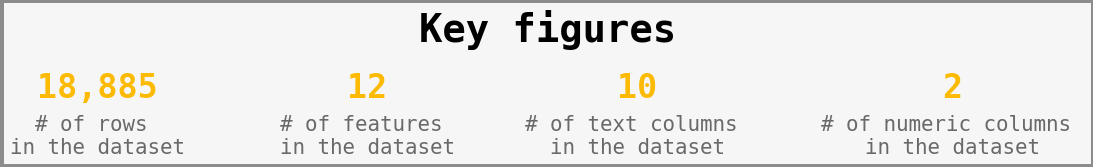

In [3]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

data = PAX_raw
art_dtypes = data.dtypes.value_counts()

fig = plt.figure(figsize=(5,2),facecolor='white')
ax0 = fig.add_subplot(1,1,1)
ax0.text(1, 0.8, "Key figures",color='black',fontsize=28, fontweight='bold', fontfamily='monospace', ha='center')

ax0.text(0, 0.4, "{:,d}".format(data.shape[0]), color='#fcba03', fontsize=24, fontweight='bold', fontfamily='monospace', ha='center')
ax0.text(0, 0.001, "# of rows \nin the dataset",color='dimgrey',fontsize=15, fontweight='light', fontfamily='monospace',ha='center')

ax0.text(0.6, 0.4, "{}".format(data.shape[1]), color='#fcba03', fontsize=24, fontweight='bold', fontfamily='monospace', ha='center')
ax0.text(0.6, 0.001, "# of features \nin the dataset",color='dimgrey',fontsize=15, fontweight='light', fontfamily='monospace',ha='center')

ax0.text(1.2, 0.4, "{}".format(art_dtypes[0]), color='#fcba03', fontsize=24, fontweight='bold', fontfamily='monospace', ha='center')
ax0.text(1.2, 0.001, "# of text columns \nin the dataset",color='dimgrey',fontsize=15, fontweight='light', fontfamily='monospace',ha='center')

ax0.text(1.9, 0.4,"{}".format(art_dtypes[1]), color='#fcba03', fontsize=24, fontweight='bold', fontfamily='monospace', ha='center')
ax0.text(1.9, 0.001,"# of numeric columns \nin the dataset",color='dimgrey',fontsize=15, fontweight='light', fontfamily='monospace',ha='center')

ax0.set_yticklabels('')
ax0.tick_params(axis='y',length=0)
ax0.tick_params(axis='x',length=0)
ax0.set_xticklabels('')

for direction in ['top','right','left','bottom']:
    ax0.spines[direction].set_visible(False)

fig.subplots_adjust(top=0.9, bottom=0.2, left=0, hspace=1)

fig.patch.set_linewidth(5)
fig.patch.set_edgecolor('#8c8c8c')
fig.patch.set_facecolor('#f6f6f6')
ax0.set_facecolor('#f6f6f6')
    
plt.show()

Now is the time for checking a number of missing values in each column. The table below will show **only columns with missing data**.

In [4]:
nulls = PAX.isnull().sum().to_frame().sort_values(by=0, ascending = False)
nulls.columns = ["Missing values"]
nulls[nulls['Missing values'] != 0]

,Missing values
Operating Airline IATA Code,63
Published Airline IATA Code,63


Only 2 columns contain missing information. However, these columns are not relevant for this analysis as these are just IATA Airline Codes. These are 2-letter codes and most of the airlines have such a code, e.g. British Airways has a code *BA* and Polish LOT has a code *LO*.

For better pre-processing, we will format the `Activity Period` to a *date type* and extract year and month components.

In [5]:
PAX.loc[:,"Activity Period"] = pd.to_datetime(PAX.loc[:,"Activity Period"].astype(str), format="%Y%m")
PAX.loc[:,"Year"] = PAX["Activity Period"].dt.year
PAX.loc[:,"Month"] = PAX["Activity Period"].dt.month

Checking what time range is reported.

In [6]:
time_begin = PAX.loc[:,"Activity Period"].min()
time_end = PAX.loc[:,"Activity Period"].max()
time_range = time_end-time_begin

print("First date: ", str(time_begin)[:11])
print("Last date: ", str(time_end)[:11])
print("Time range in days:", time_range.days)
print("Time range in months:", time_range/np.timedelta64(1,"M"))

First date:  2005-07-01 
Last date:  2018-06-01 
Time range in days: 4718
Time range in months: 155.00934310766135


# 1.2 Airline traffic generation

In the beginning, it is worth looking at the overall number of passengers (PAX) at San Francisco airport over time. Keep in mind that the graph below shows PAX numbers in thousands.

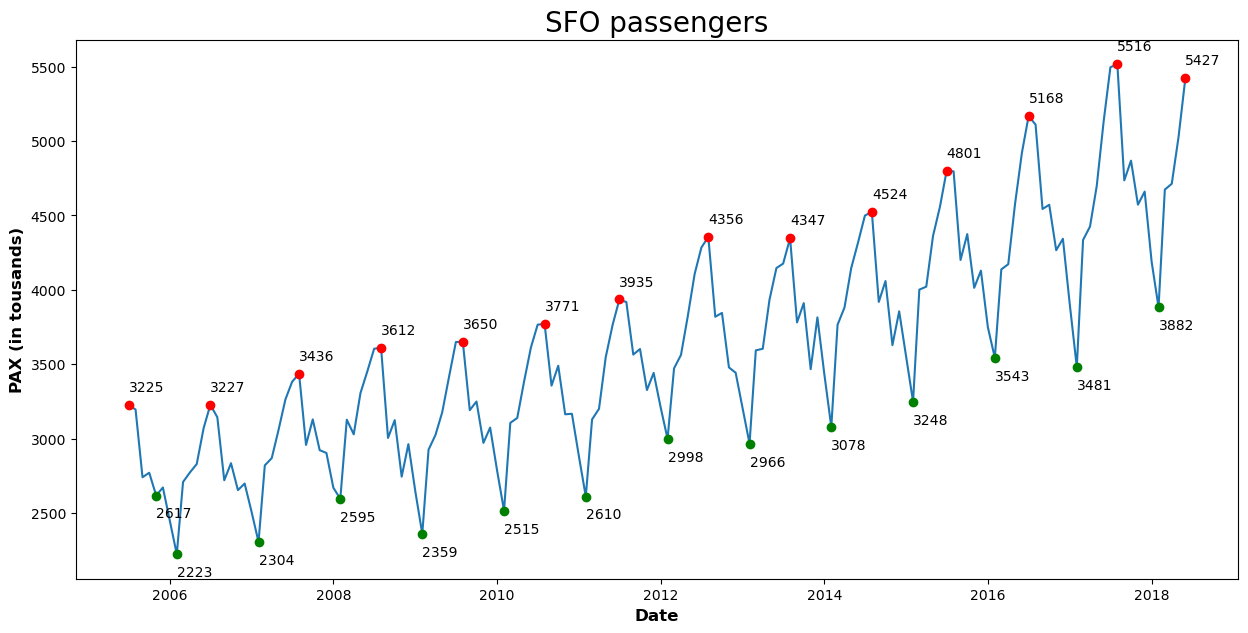

In [7]:
PAX_yr = PAX.groupby(["Activity Period"])["Passenger Count"].sum().divide(1000)

fig, ax = plt.subplots(figsize=(15,7))

#Plotting the main PAX line
sns.lineplot(x=PAX_yr.index, y=PAX_yr.values, markers=True, ax=ax,zorder=0)

# Plotting vertical lines for beginning of each year 
#years = PAX_yr.index.year.unique()
#for year in years:
#    plt.axvline(x=year, ls = "--", c = "#3f5261", alpha=0.7)
    
# Looking for maximum PAX for each year
PAX_yr_maxs = PAX_yr.groupby(PAX_yr.index.year).max()
PAX_yr_max_complete = PAX_yr[PAX_yr.isin(PAX_yr_maxs.values)].to_frame()

# Marking points of interest
plt.scatter(PAX_yr_max_complete.index, PAX_yr_max_complete.values, color = "red", zorder=2)

#Annotating each marker
for t,v in PAX_yr_max_complete.reset_index().values:
    ax.text(t,v+90,int(v))
    
# Looking for minimum PAX for each year
PAX_yr_mins = PAX_yr.groupby(PAX_yr.index.year).min()
PAX_yr_min_complete = PAX_yr[PAX_yr.isin(PAX_yr_mins.values)].to_frame()
plt.scatter(PAX_yr_min_complete.index, PAX_yr_min_complete.values, color = "green", zorder=2)
for t,v in PAX_yr_min_complete.reset_index().values:
    ax.text(t,v-150,int(v))
    
plt.title("SFO passengers", size = 20)
plt.xlabel("Date", fontweight="bold", size = 12)
plt.ylabel("PAX (in tousands)", fontweight="bold", size = 12)
plt.show()

The number of passengers is generally increasing (trend) with a clear seasonal pattern with a period of about one year. The traffic peak is around summertime while the lowest traffic is during wintertime at the beginning of the year.
The heatmap below shows what amount of traffic various airlines generated through the years (in thousands).

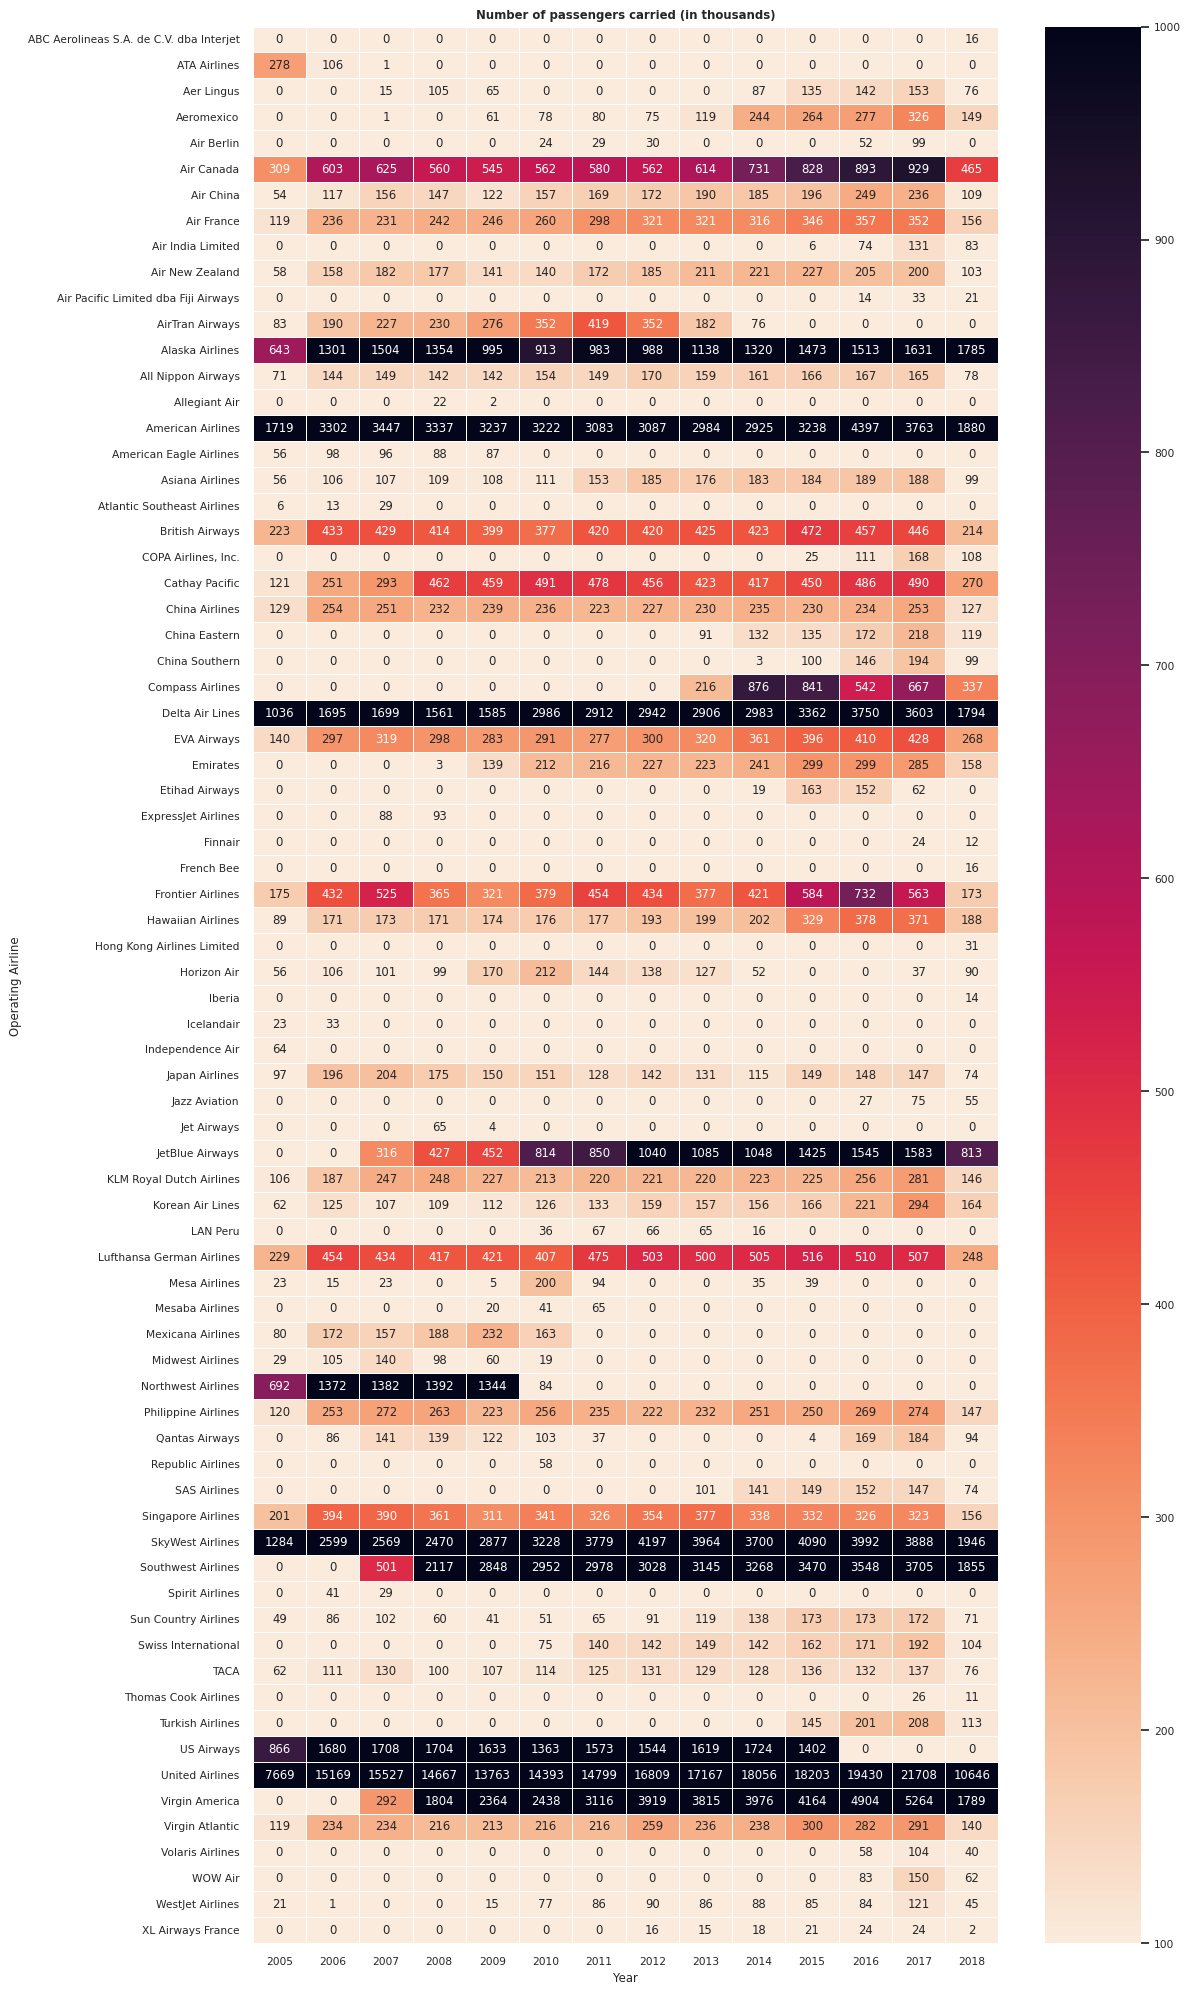

In [8]:
PAX_airline_yr = PAX.groupby(["Year","Operating Airline"])["Passenger Count"].sum().divide(1000)
PAX_airline_yr = PAX_airline_yr.reset_index()
pivot_1 = PAX_airline_yr.pivot_table(values="Passenger Count", index="Operating Airline", columns="Year", fill_value=0)
pivot_1.loc["United Airlines",:] = pivot_1.loc["United Airlines",:] + pivot_1.loc["United Airlines - Pre 07/01/2013",:]
pivot_1.drop("United Airlines - Pre 07/01/2013",axis=0, inplace=True)

#dropping the small airlines
smallest_airlines = pivot_1[pivot_1.sum(axis=1)<13]
pivot_1 = pivot_1.drop(smallest_airlines.index, axis=0)

sns.set(font_scale=0.7)
fig1 = plt.figure(figsize=(12,20))
p1 = sns.heatmap(pivot_1, annot=True, linewidths=.5, vmin=100, vmax=1000, fmt='.0f', cmap=sns.cm.rocket_r)
p1.set_title("Number of passengers carried (in thousands)", fontweight="bold")
p1.set_yticklabels(p1.get_yticklabels(), rotation=0)
plt.tight_layout()
plt.show()

Now let's see what airlines generate the most of the traffic. To find that we will look at the mean number of passengers per airline each year and calculate its share in the total traffic.

In [9]:
avg_airline = pivot_1.mean(axis=1)
TOP5_airlines = avg_airline.nlargest(5).to_frame().mul(1000).astype("int64")
TOP5_airlines.columns = ["Mean no. of passengers per year"]
sum_of_all = TOP5_airlines.loc[:,"Mean no. of passengers per year"].sum()
TOP5_airlines.loc[:,"Share [%]"] = TOP5_airlines.loc[:,"Mean no. of passengers per year"].div(sum_of_all).mul(100).round(1)
TOP5_airlines

,Mean no. of passengers per year,Share [%]
Operating Airline,,
United Airlines,15571737,57.5
SkyWest Airlines,3184454,11.8
American Airlines,3115884,11.5
Virgin America,2703137,10.0
Delta Air Lines,2486702,9.2


# 1.3 TOP 5 BIGGEST AIRLINES

**1. United Airlines**

United is a huge American airline operating worldwide with strong presence in the Asia-Pacific region. It is founder of Star Alliance – international network of cooperating airlines. United has a fleet of over 760 airplanes of various types and employs over 88000 people. Its biggest hub is in Chicago O’Hare airport although San Francisco is its main West Coast hub.

**2. SkyWest Airlines**

SkyWest Airlines is an American airline operating on the regional North American market. Its flights are usually contracted by and operated under the name of other airlines. Its biggest clients are delta and United. SkyWest fleet consists mostly of regional jets (Bombardier CRJ series and Embraer 175) in number about 470. The airline ordered 100 brand new Embraer 175-E2 and 100 Mitsubishi MRJ90 jest to further expand its fleet.

**3. American Airlines**

American Airline (AA) is enormous American airline with headquarter in in Fort Worth, Texas. It has impressive fleet of over 950 airplanes and employs over 140 000 people. It is the founding member of Oneworld alliance. AA’s biggest hub is in Dallas/Fort Worth International Airport.

**4. Virgin America**

Virgin America airline was an American airline with headquarters in San Francisco operating until 2018 when it was merged with Alaska Airlines. Its business model was to operate low-fare services on the American West coast. The name was licences from UK-based Virgin Group which also controls brands of Virgin Atlantic and Virgin Australia. Its fleet consisted of 67 airplanes, mostly Airbus.

**5. Delta Airlines**

Delta Airlines is immense American airline with headquarters in Atlanta, Georgia. It is the founding member of SkyTeam airline alliance. Delta has a huge airplane fleet of 876 airplanes and employs over 86 000 people worldwide. Its main hub is in Atlanta International Airport. Historically, main milestones in term of Delta’s growth were two merges: with Western Airlines in 1987 and with Nortwest Airlines in 2009.


# 1.4 THE SMALLEST AIRLINES

From the pure curiosity let's create a separate table the smallest airlines which operated at SFO.

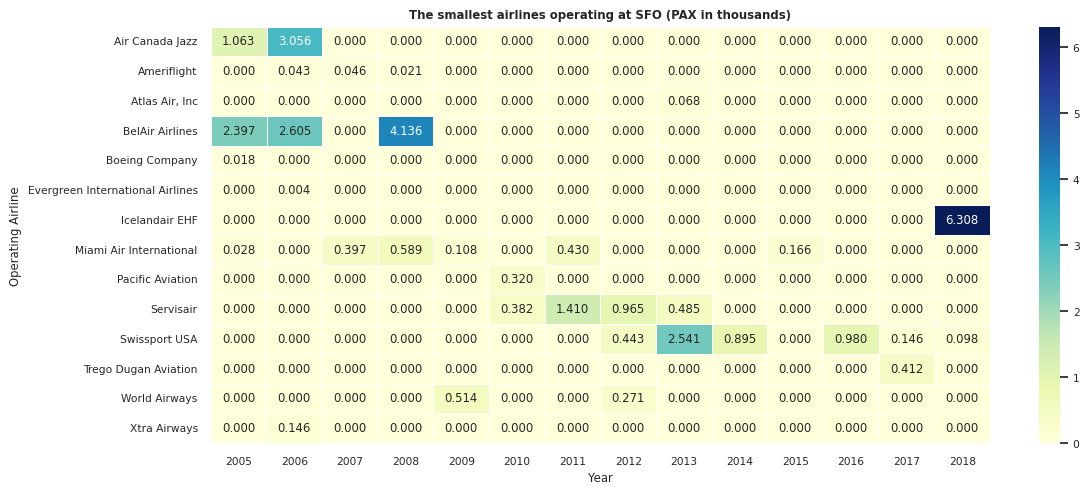

In [10]:
sns.set(font_scale=0.7)
fig2 = plt.figure(figsize=(12,5))
p2 = sns.heatmap(smallest_airlines, annot=True, linewidths=.5, cmap="YlGnBu", fmt='.3f')
p2.set_title("The smallest airlines operating at SFO (PAX in thousands)", fontweight ="bold")
p2.set_yticklabels(p2.get_yticklabels(), rotation=0)
plt.tight_layout()
plt.show()

Indeed, the smallest airlines operating at SFO do not generate much of a traffic and in some years no traffic at all. The "airways" themselves are not always the real airways, e.g. the Boeing Company.

# 1.5 Passanger traffic overview

Below there is a heatmap showing the number of passengers in each month for years 2005-2018 (in thousands). We can see a peak in traffic around June-August. The highest number reported so far is in August 2017: 5 497 000 passengers. Such a peak makes sense as this is a typical holiday period.

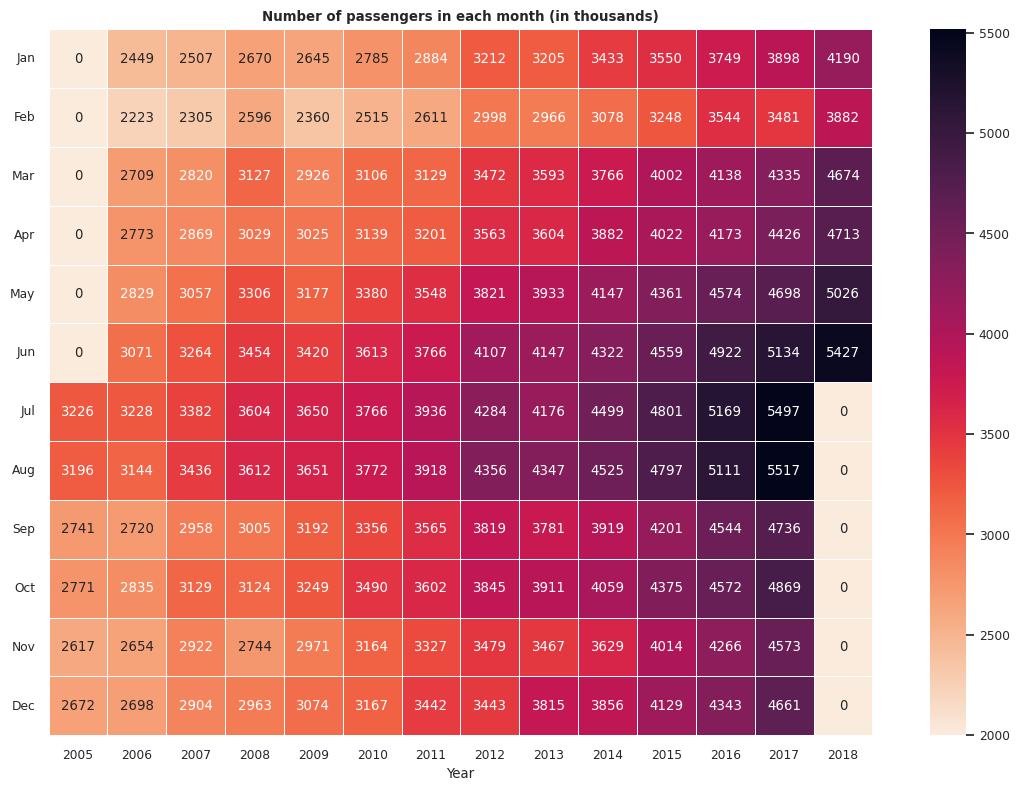

In [11]:
PAX_month_yr = PAX.groupby(["Year","Month"])["Passenger Count"].sum().divide(1000).round()
PAX_month_yr = PAX_month_yr.reset_index()

pivot_2 = PAX_month_yr.pivot_table(values="Passenger Count",index="Month",columns="Year", fill_value=0)
pivot_2.index=["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

sns.set(font_scale=0.8)
fig = plt.figure(figsize=(12,8))
g = sns.heatmap(pivot_2, annot=True, linewidths=.5, fmt="d", square =True, vmin=2000, cmap=sns.cm.rocket_r)
g.set_title("Number of passengers in each month (in thousands)", fontweight="bold")
g.set_yticklabels(g.get_yticklabels(), rotation=0)
plt.tight_layout()
plt.show()

The line plot below shows the share of traffic being generated by each geographic region (excluding North America). The biggest share have Asia and Europe.

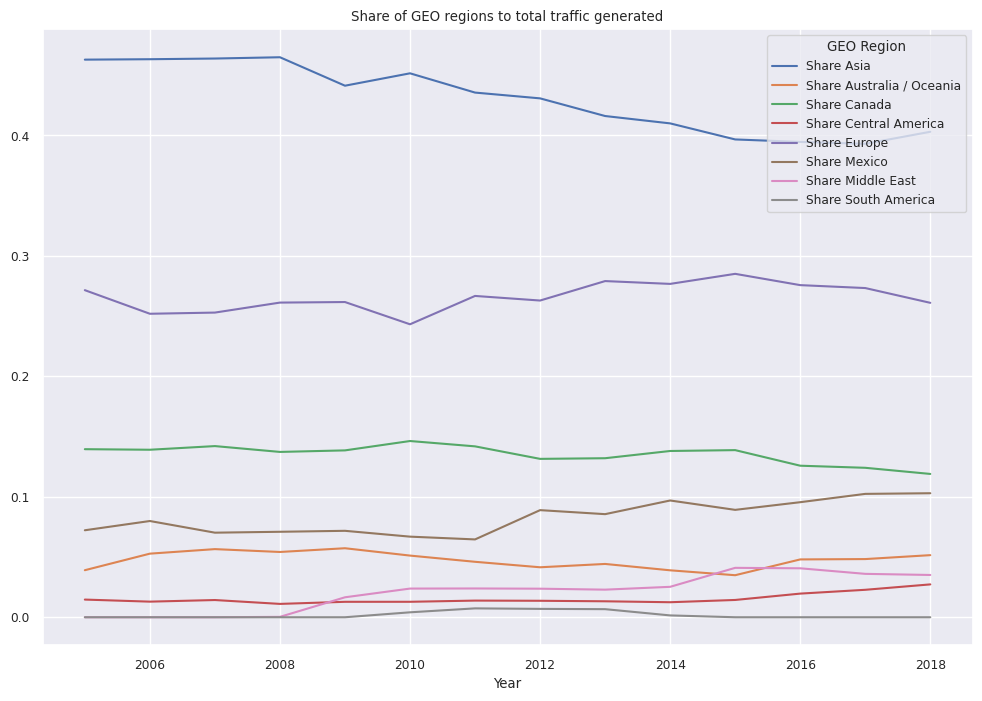

In [12]:
bbb = PAX.groupby(["Year","GEO Region"])["Passenger Count"].sum()
bbb = bbb.reset_index()

pivot_5 = bbb.pivot_table(values="Passenger Count",index="Year",columns="GEO Region", fill_value=0)
pivot_5 = pivot_5.drop("US",axis=1)
pivot_5["Total"] = pivot_5.sum(axis=1)

for col in pivot_5.columns[:-1]:
        pivot_5["Share " + str(col)]=pivot_5[col]/pivot_5["Total"]

ratios_5 = pivot_5.iloc[:,-8:]
ratios_5.plot(figsize=(12,8), title="Share of GEO regions to total traffic generated")
plt.show()

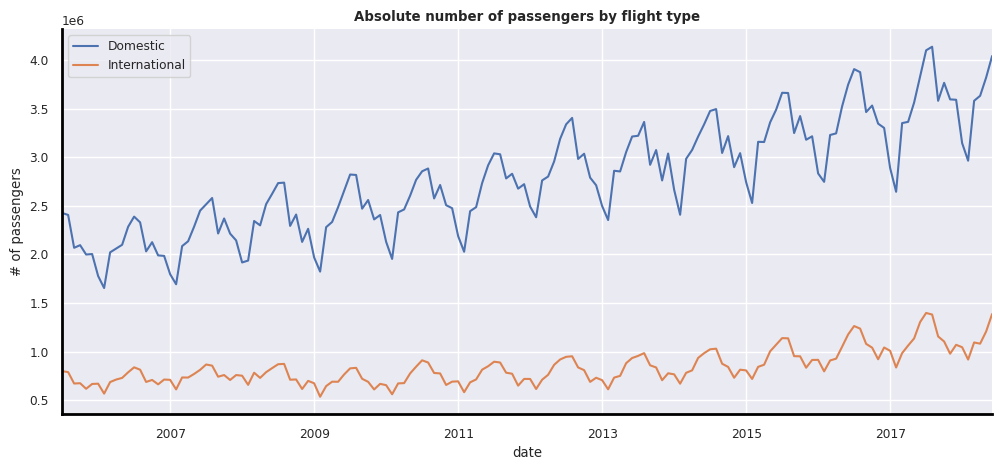

In [13]:
TS2 = PAX[PAX["GEO Summary"]=="Domestic"].groupby("Activity Period")["Passenger Count"].sum()
TS3 = PAX[PAX["GEO Summary"]=="International"].groupby("Activity Period")["Passenger Count"].sum()
TS = pd.concat([TS2,TS3],axis=1)
TS.columns=["Domestic","International"]

ax = TS.plot(figsize=(12,5))
ax.set_title("Absolute number of passengers by flight type", fontweight="bold")
ax.set_xlabel('date')
ax.set_ylabel('# of passengers')
for loc in ['bottom', 'left']:
    ax.spines[loc].set_visible(True)
    ax.spines[loc].set_linewidth(2)
    ax.spines[loc].set_color('black')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

# 2. Time Series Forecasting

# 2.1 SARIMAX

The plot below shows overall traffic on the airport over time. It looks like it has a linear character but a proper decomposition is required.

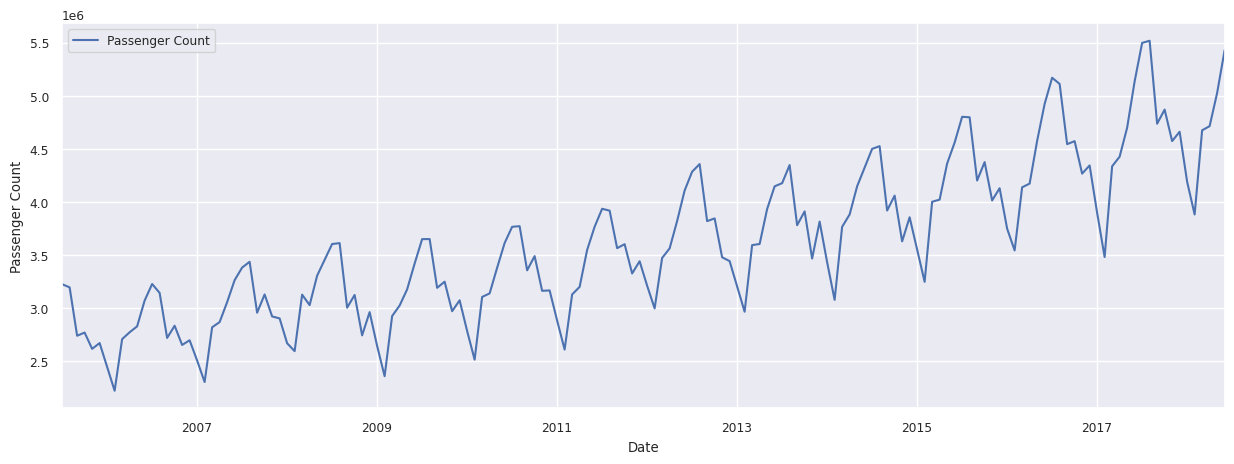

In [14]:
TS1 = PAX.groupby("Activity Period")["Passenger Count"].sum().to_frame()

fig, ax = plt.subplots(1,1,figsize=(15,5))
TS1.plot(ax=ax)
ax.set_xlabel("Date")
ax.set_ylabel("Passenger Count")
plt.grid(True)
plt.show()

The Augmented Dickey-Fuller test can be used to test for stationarity of our time series. The null hypothesis of the test is that the time series is not stationary (has some time-dependent structure).
* **Null Hypothesis (H0):** if failed to be rejected (high p-value) means it is non-stationary
* **Null Hypothesis (H1):** if H0 is rejected (low p-value) means it is stationary

In [15]:
from statsmodels.tsa.stattools import adfuller

results = adfuller(TS1["Passenger Count"])
print('ADF Statistic: %f' % results[0])
print('p-value: %f' % results[1])

ADF Statistic: 1.133106
p-value: 0.995489


No surprise. P-value is 0.99 (we don't reject H0) - time series is not stationary. 

To better understand the time series behaviour I will decompose it into 3 main components: 
* trend
* seasonality
* residuals

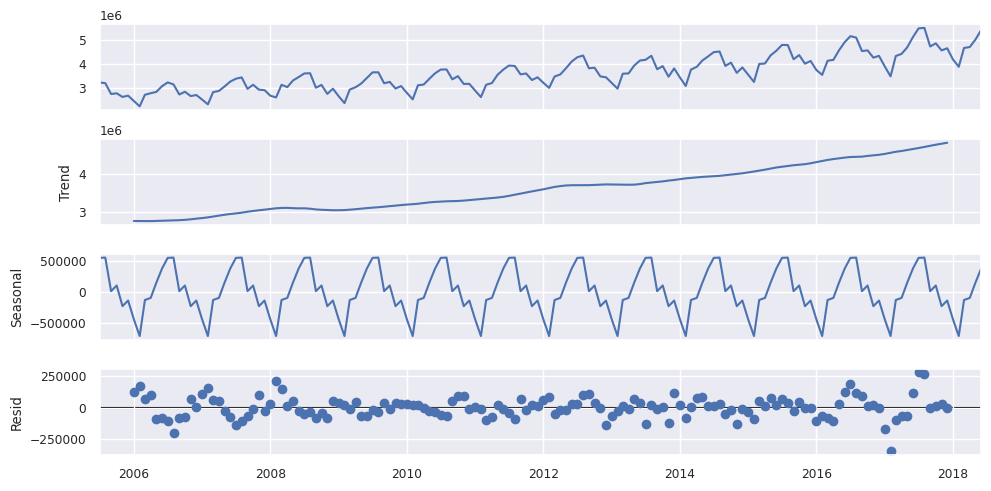

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams['figure.figsize'] = 10, 5
# Additive decomposition
decomposed_add = seasonal_decompose(TS1, model="additive")
add = decomposed_add.plot()
plt.show()

The model seems to have a 12-month seasonal trend which makes sense as usually every year a holiday period is more busy at airports. In order to stationarize time series and to ARMA model I will transform this time series by taking the 1-month difference.


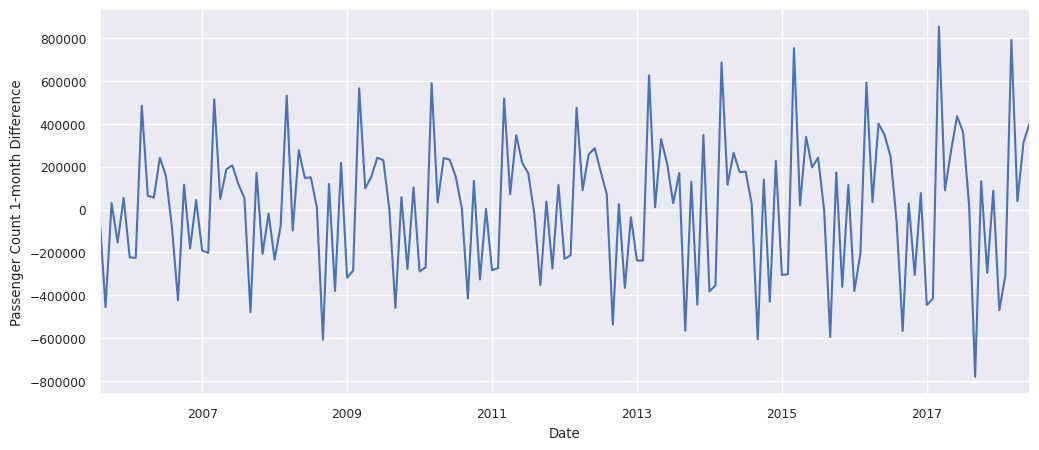

In [17]:
TS1_diff = TS1.diff().dropna()

plt.figure(figsize=(12,5))
ax = TS1_diff["Passenger Count"].plot()
ax.set_xlabel("Date")
ax.set_ylabel("Passenger Count 1-month Difference")
plt.grid(True)
plt.show()

In [18]:
results = adfuller(TS1_diff["Passenger Count"])
print('ADF Statistic: %f' % results[0])
print("P-value of a test is: {}".format(results[1]))

ADF Statistic: -2.950493
P-value of a test is: 0.039783614803849204


The p-value of 0.0397 is small enough to reject the null hipothesis that the time series is non-stationary. However, the plot above shows still a seasonality.

Let's see what would be result of the same test is we take a second difference. Pleas note that you have to be aware of risk of so called overdifferencing time series.


In [19]:
results = adfuller(TS1.diff().diff().dropna()["Passenger Count"])
print('ADF Statistic: %f' % results[0])
print("P-value of a test is: {}".format(results[1]))

ADF Statistic: -5.647791
P-value of a test is: 1.0020534478927208e-06


Indeed the p-value test dropped even more. However, often the simplest solutions work the best - therefore I will stay with a simple single difference.

* **AutoCorrelation Plot** (ACF) shows a correlation between "a signal" (our value) with its delayed occurance (observation) in a function of time delta between them (so called lag).
* **Partial AutoCorrelation Plot** (PCAF) is similar to ACF but the effect of the shorter lags is removed.

Things to remember:

| Plot |       AR(p)      |       MA(q)      | ARMA(p,q) |
|:----:|:----------------:|:----------------:|:---------:|
|  ACF |     Tails off    | Cuts after lag q | Tails off |
| PACF | Cuts after lag p |     Tails off    | Tails off |

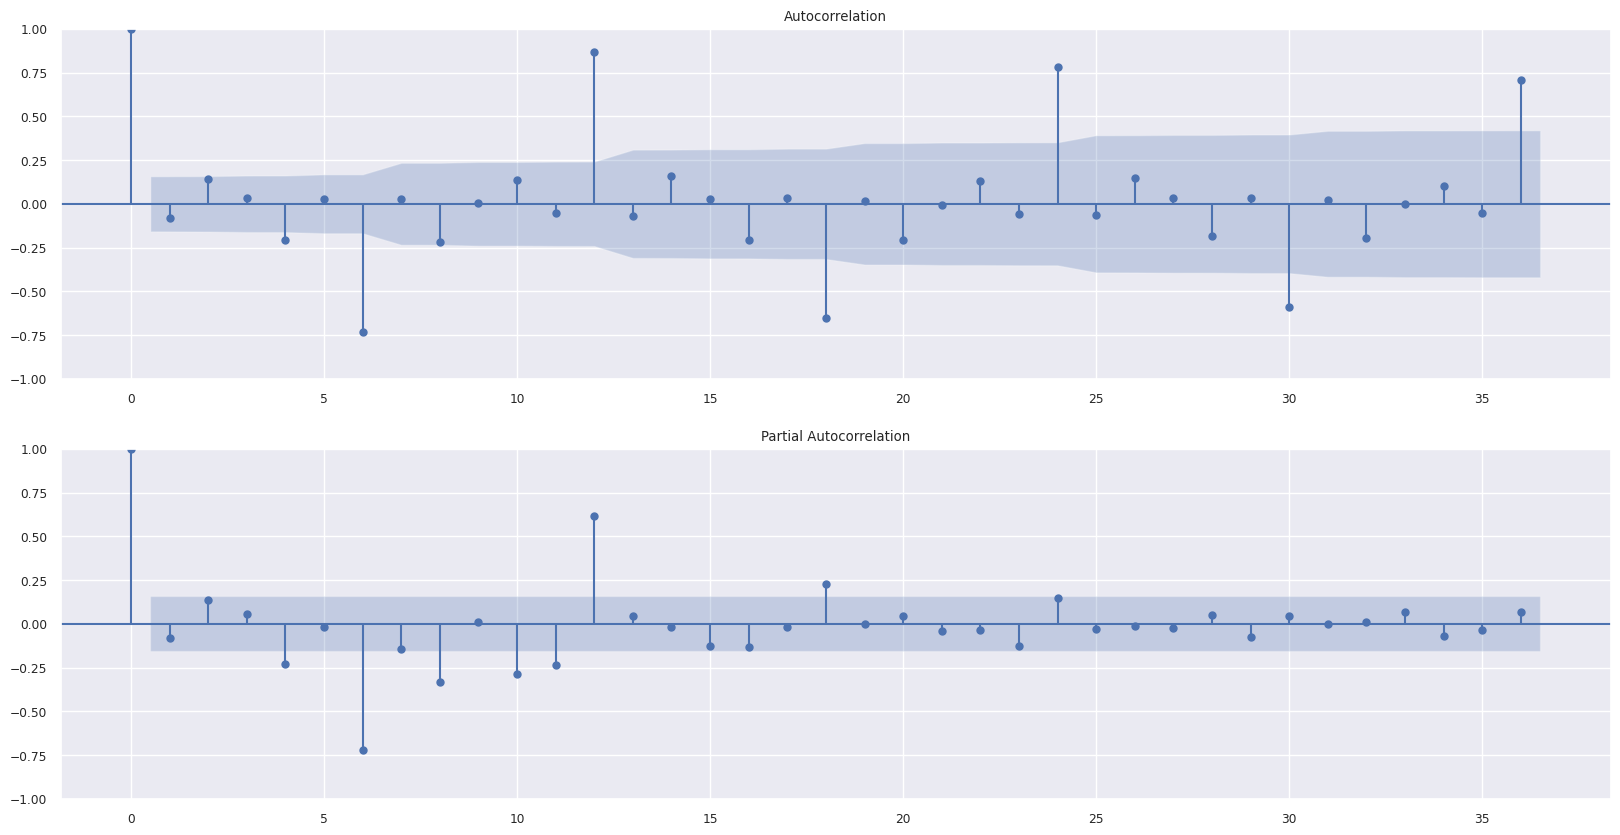

In [20]:
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig,ax = plt.subplots(2,1,figsize=(20,10))
plot_acf(TS1_diff, lags=36, ax=ax[0])
plot_pacf(TS1_diff, lags=36, ax=ax[1])
plt.show()

The lag plot below allows to check a lag correlation. If you can identify a structure in the plot, the data doesn't look random and the autocorrelation is indeed present. In this case I will check the lag plot for lags of 1 and 2 months.


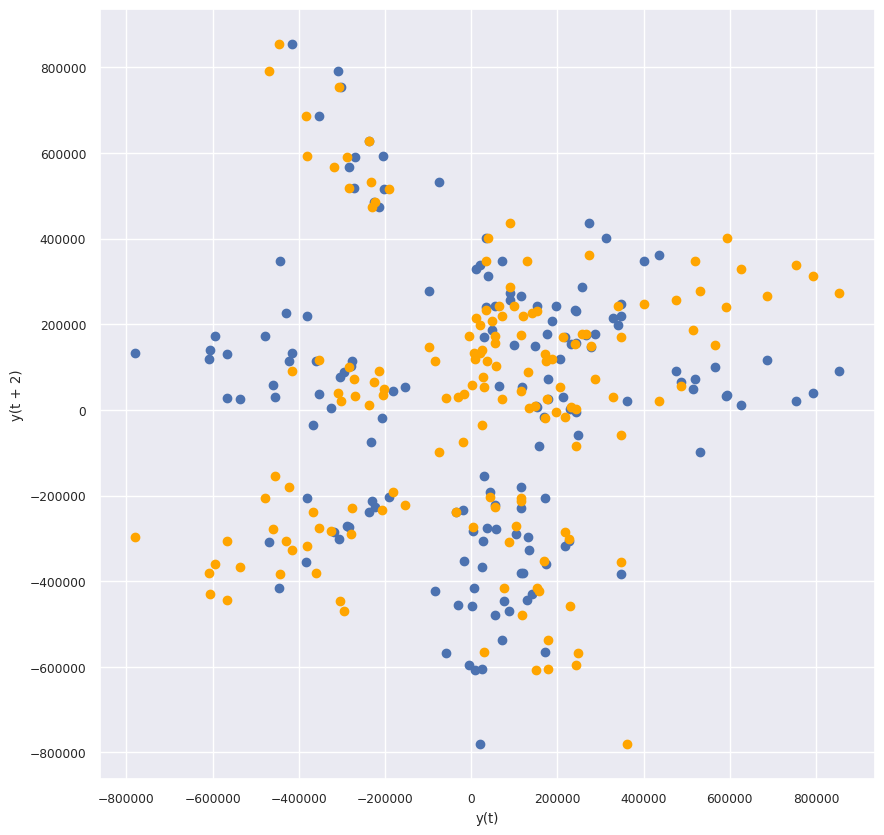

In [21]:
from pandas.plotting import lag_plot

fig, ax = plt.subplots(figsize=(10, 10))
ax = lag_plot(TS1_diff, lag=1)
ax = lag_plot(TS1_diff, lag=2, c="orange")

plt.show()

In the next step we will iterate over p and q parameters of ARIMA model and compute for each **Akaike Information Critera (AIC)** and **Bayesian Information Criteria (BIC)**. BIC is giving additional penalty for more parameters.

In [22]:
from statsmodels.tsa.arima_model import ARIMA

arima_df = pd.DataFrame(columns=["p","q","aic","bic"])

i=0
# Loop over p values from 0-3
for p in range(4):
    # Loop over q values from 0-3
    for q in range(4):
        
        try:
            # creating and fitting ARIMA(p,1,q) model
            model = ARIMA(TS1.astype(float), order=(p,1,q))
            results = model.fit()
            
            # Printing order, AIC and BIC
            arima_df.loc[i,"p"] = p
            arima_df.loc[i,"q"] = q
            arima_df.loc[i,"aic"] = results.aic
            arima_df.loc[i,"bic"] = results.bic
            i = i+1
        except:
            i = i+1
    
arima_df["sum_aic_bic"] = arima_df["aic"]+arima_df["bic"]
arima_df.sort_values(by="sum_aic_bic", ascending=False, inplace=True)
arima_df

,p,q,aic,bic,sum_aic_bic


Let's look now at SARIMAX(2,1,1)x(0,1,0,12) diagnostics summary and diagnostics plots.

In [23]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

TS1.index.freq = TS1.index.inferred_freq
model2 = SARIMAX(TS1, order=(2,1,1), seasonal_order=(0,1,0,12))
results = model2.fit()
results.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24650D+01    |proj g|=  3.60520D+00

At iterate    5    f=  1.18163D+01    |proj g|=  1.66732D-03

At iterate   10    f=  1.18163D+01    |proj g|=  2.12871D-02

At iterate   15    f=  1.18160D+01    |proj g|=  8.97950D-03

At iterate   20    f=  1.18152D+01    |proj g|=  4.18233D-02


 This problem is unconstrained.



At iterate   25    f=  1.18123D+01    |proj g|=  5.80991D-03

At iterate   30    f=  1.18101D+01    |proj g|=  4.56714D-02

At iterate   35    f=  1.18082D+01    |proj g|=  1.32206D-03

At iterate   40    f=  1.18078D+01    |proj g|=  7.29773D-04

At iterate   45    f=  1.18078D+01    |proj g|=  5.12188D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     47     56      1     0     0   1.818D-06   1.181D+01
  F =   11.807781462156932     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                     Passenger Count   No. Observations:                  156
Model:             SARIMAX(2, 1, 1)x(0, 1, [], 12)   Log Likelihood               -1842.014
Date:                             Thu, 13 Jul 2023   AIC                           3692.028
Time:                                     10:22:15   BIC                           3703.879
Sample:                                 07-01-2005   HQIC                          3696.844
                                      - 06-01-2018                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9479      0.025     38.102      0.000       0.899       0.997
ar.L2          0.0096      0.024      0.393      0.694      -0.038       0.057
ma.L1         -0.9998      0.092    -10.893      0.000      -1.180      -0.820
sigma2      8.149e+09   1.13e-11   7.22e+20      0.000    8.15e+09    8.15e+09
===================================================================================
Ljung-Box (L1) (Q):                  11.95   Jarque-Bera (JB):                 8.76
Prob(Q):                              0.00   Prob(JB):                         0.01
Heteroskedasticity (H):               1.04   Skew:                             0.32
Prob(H) (two-sided):                  0.89   Kurtosis:                         4.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.28e+35. Standard errors may be unstable.
"""

Summary explanations:

1. **Ljung-Box (Q)** - This test is used to check for the *lack of fit* of a time series model. The null hypothesis here is there are no correlations in the residuals. In our case we reject the null hypothesis what means that residuals are somehow correlated.

2. **Jarque-Bera (JB)** - This is a test for normality of distributon. It is basing on values of skewness and kurtosis where for the normal distibution these values should be respectively 0 and 3. The null hypothesis of the test is that the sample comes from the normal distribution. Ander this hypothesis the chi-squared distribution with 2 degrees of freedom can be used. In our case JB statistics is 8.76 which gives probability of 0.01 - meaning that we don't reject the null hypothesis.

3. **Heteroskedasticity (H)** - Checks if the variance is constant


When looking at the diagnostic plots below we are interested in:
1. Standardized residual - there are no obvious patterns in the residuals
2. Histogram plus kde estimate - KDE should be very similar to the normal distribution
3. Normal Q-Q - points should lie on the straight line
4. Correlogram - 95% of correlations for lag greater than one should not be significant

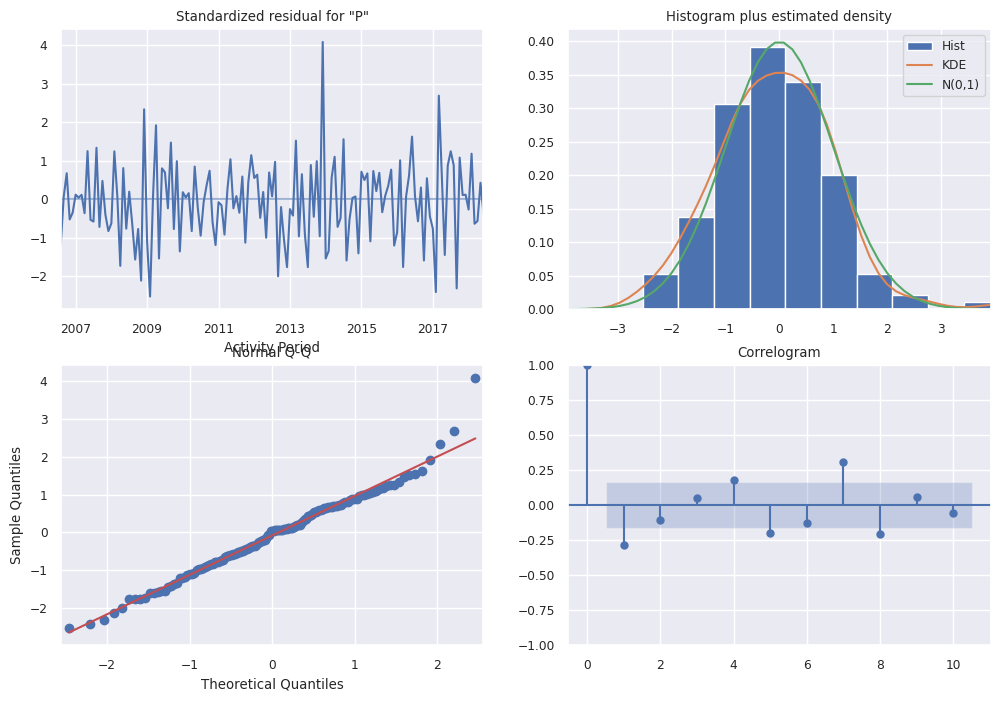

In [24]:
plt.rcParams['figure.figsize'] = 12, 8
plot = results.plot_diagnostics()
plt.show()

We see that the fit is not perfect but satisfactory for now. Let's proceed to forecasting.

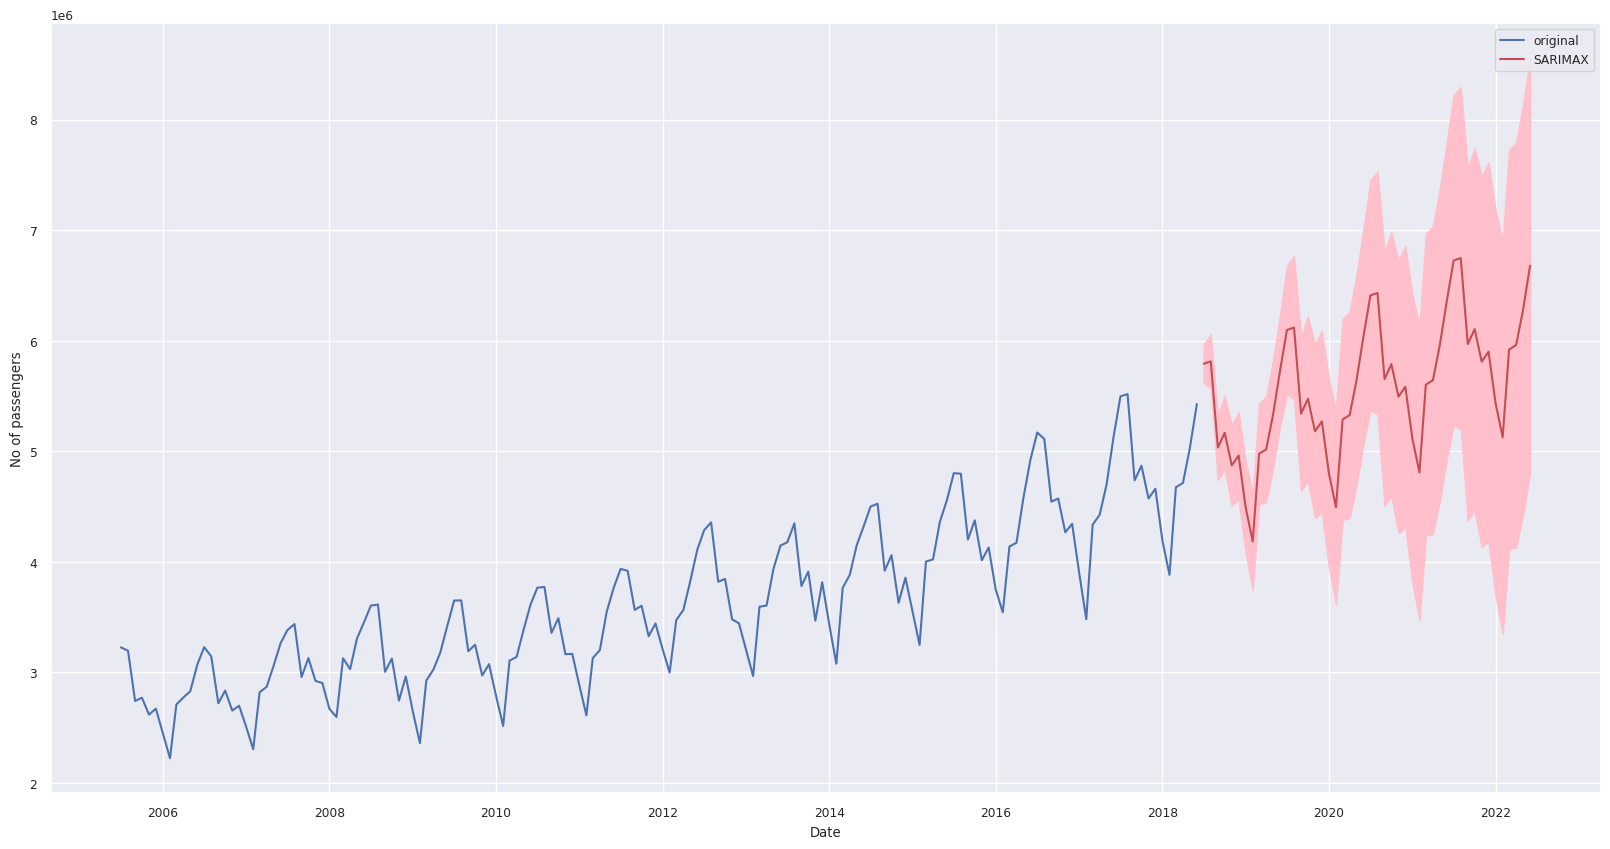

In [25]:
# Create SARIMA mean forecast
forecast = results.get_forecast(steps=48)
lower = forecast.conf_int()["lower Passenger Count"]
upper = forecast.conf_int()["upper Passenger Count"]

# Plot mean SARIMA predictions
fig,ax = plt.subplots(1,1,figsize=(20,10))

plt.plot(TS1, label='original')
plt.plot(forecast.predicted_mean, label='SARIMAX', c="r")
plt.fill_between(forecast.conf_int().index, 
                 lower,upper,
                 color='pink')
plt.xlabel('Date')
plt.ylabel('No of passengers')
plt.legend()
plt.show()

The plot above shows predictions using SARIMAX(2,1,1)x(0,1,0,12). The red line indicates the mean and the pink area is bounded by 95% confidence intervals. According to this prediction in 2022 a number of passengers can reach 8 millions at the peak time.

# 3. Prophet  

In this section a Facebook's (now Meta) library called "Prophet" will be used.

In [26]:
#!pip install cmdstanpy==0.9.68  -q
#!pip install fbprophet -q
!pip install prophet

In [27]:
#import fbprophet
from prophet import Prophet
#print(f'Prophet {prophet.__version__}')

Prophet requires from a database to contain two columns: `ds` for dates and `y` for values.

In [28]:
df = PAX_yr.reset_index()
df = df.rename({'Activity Period':'ds', 'Passenger Count':'y'},axis=1)
df.head()

,ds,y
0,2005-07-01,3225.769
1,2005-08-01,3195.866
2,2005-09-01,2740.553
3,2005-10-01,2770.715
4,2005-11-01,2617.333


Prophet follows a scikit learn scheme where we have to initialise an instance and then to fit it to a database. At the moment of initialisation it is possible to specifiy some additional parameters. A very good guide what can be tuned is provided on [Prophets page about hyperparameters tuning](https://facebook.github.io/prophet/docs/diagnostics.html#hyperparameter-tuning).

In [29]:
m = Prophet(changepoint_prior_scale=0.004,
                seasonality_prior_scale=20,
                seasonality_mode='multiplicative',
                changepoint_range=0.9)
m.fit(df)

10:22:35 - cmdstanpy - INFO - Chain [1] start processing
10:22:35 - cmdstanpy - INFO - Chain [1] done processing


After fitting a model it is ready to make predictions. However, before doing it, Prohet expects an empty database with a fixed format to be populated. It can be easily done with `.make_future_datframe` method.

In [30]:
future = m.make_future_dataframe(periods=365*3)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1246,2021-05-27,6011.627171,5898.660298,6123.449356
1247,2021-05-28,6010.995117,5905.622342,6122.840325
1248,2021-05-29,6009.121892,5905.023593,6119.314829
1249,2021-05-30,6006.312395,5901.770208,6112.275765
1250,2021-05-31,6002.896204,5890.833972,6108.647537


The fortcast can be easiliy plotted with build-in`.plot` method.

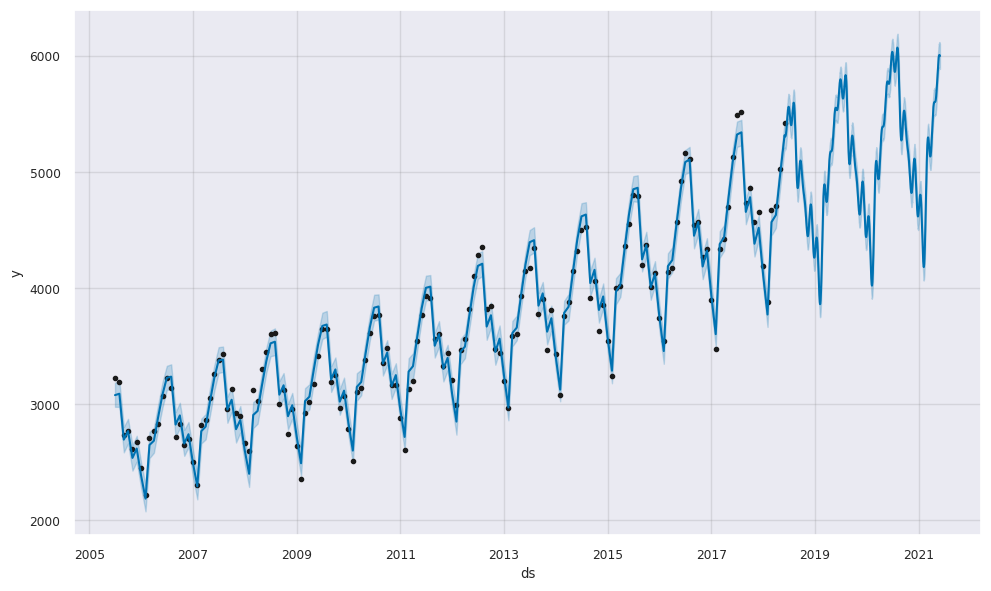

In [31]:
m.plot(forecast)

Now we can decompose the prediction.

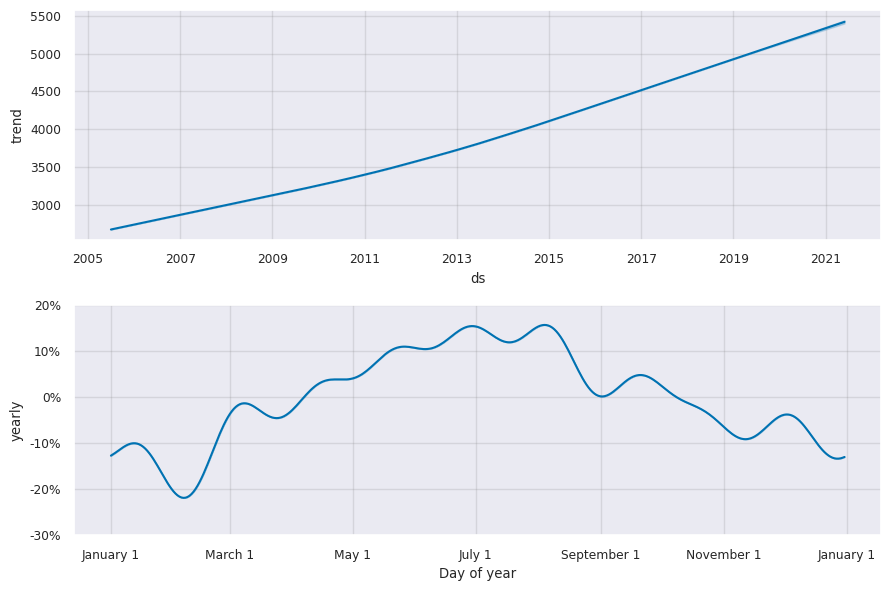

In [32]:
m.plot_components(forecast)

Now it is possible to perform a diagnostics using Cross-Validation.

In [33]:
import logging
from prophet.diagnostics import cross_validation, performance_metrics

logging.getLogger('fbprophet').setLevel(logging.WARNING)

df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')

  0%|          | 0/21 [00:00<?, ?it/s]

10:22:40 - cmdstanpy - INFO - Chain [1] start processing
10:22:40 - cmdstanpy - INFO - Chain [1] done processing
10:22:40 - cmdstanpy - INFO - Chain [1] start processing
10:22:41 - cmdstanpy - INFO - Chain [1] done processing
10:22:41 - cmdstanpy - INFO - Chain [1] start processing
10:22:42 - cmdstanpy - INFO - Chain [1] done processing
10:22:42 - cmdstanpy - INFO - Chain [1] start processing
10:22:42 - cmdstanpy - INFO - Chain [1] done processing
10:22:43 - cmdstanpy - INFO - Chain [1] start processing
10:22:43 - cmdstanpy - INFO - Chain [1] done processing
10:22:44 - cmdstanpy - INFO - Chain [1] start processing
10:22:44 - cmdstanpy - INFO - Chain [1] done processing
10:22:44 - cmdstanpy - INFO - Chain [1] start processing
10:22:45 - cmdstanpy - INFO - Chain [1] done processing
10:22:45 - cmdstanpy - INFO - Chain [1] start processing
10:22:45 - cmdstanpy - INFO - Chain [1] done processing
10:22:46 - cmdstanpy - INFO - Chain [1] start processing
10:22:46 - cmdstanpy - INFO - Chain [1]

In [34]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,39 days,25551.096717,159.847104,129.636578,0.036260,0.036095,0.037021,0.40
1,40 days,23243.087488,152.456838,120.151850,0.033297,0.033198,0.033942,0.44
2,41 days,22338.780296,149.461635,117.407126,0.033107,0.033198,0.033743,0.44
3,44 days,20505.827999,143.198561,112.357476,0.031675,0.033198,0.032230,0.46
4,45 days,18211.225279,134.948973,105.786616,0.030131,0.029697,0.030608,0.48


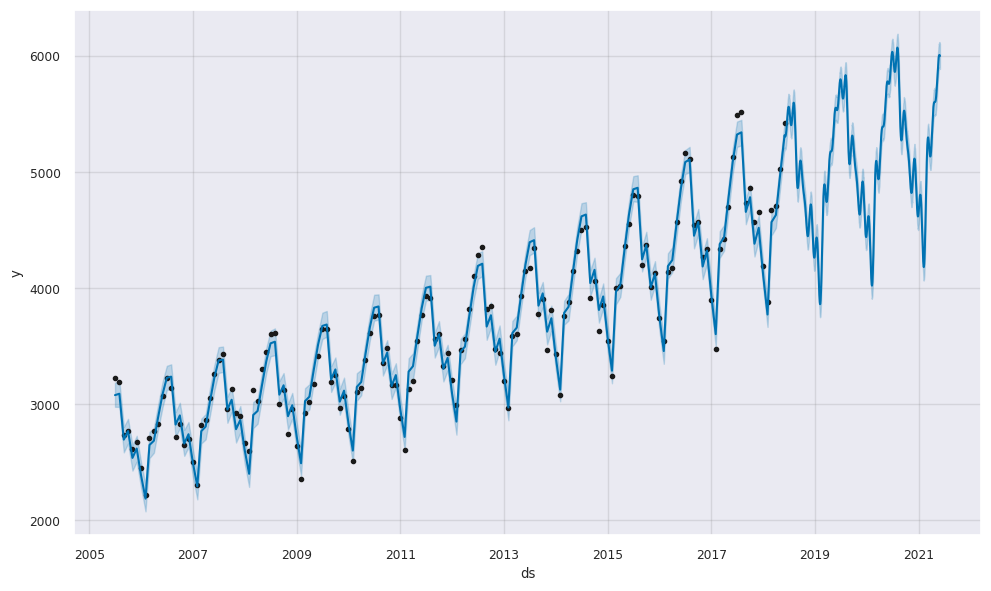

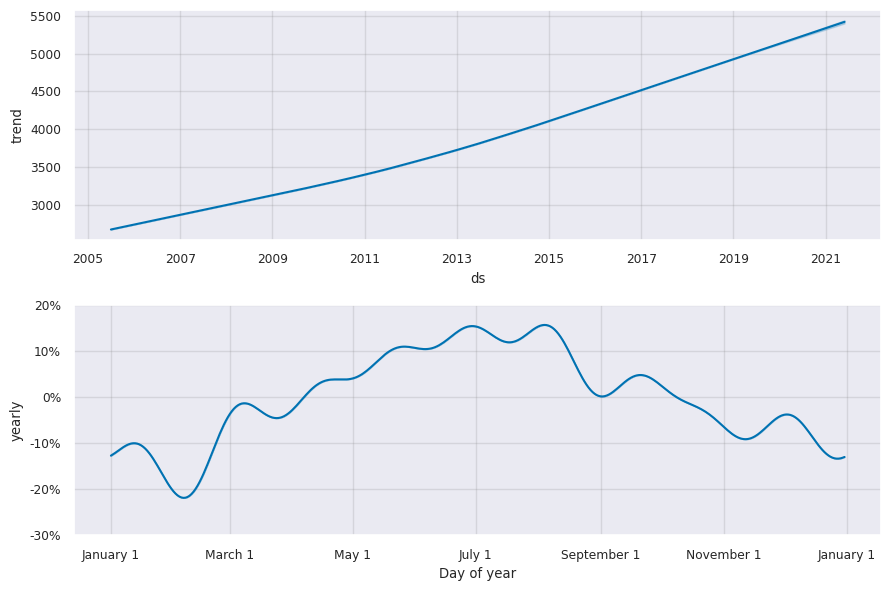

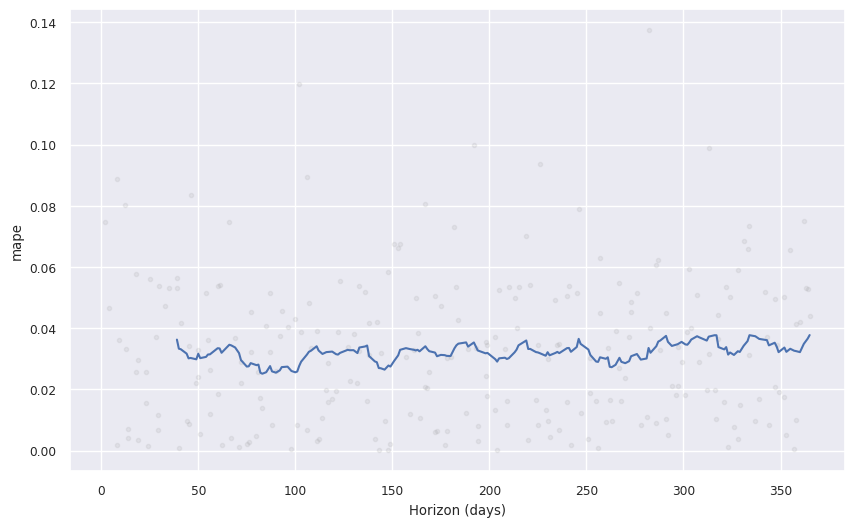

In [35]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')
plt.show()